# Emotion Classification Using DL Models

## imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, top_k_accuracy_score
)
from sklearn.preprocessing import LabelEncoder
import json

## load datasets

In [16]:
train_df = pd.read_csv("../data/train.csv", sep=';')
val_df = pd.read_csv("../data/val.csv", sep=';')
test_df = pd.read_csv("../data/test.csv", sep=';')

train_df.columns = ['text', 'label']
val_df.columns = ['text', 'label']
test_df.columns = ['text', 'label']

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")
train_df.head()

Train: (16000, 2), Val: (2000, 2), Test: (2000, 2)


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## encode labels

In [17]:
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
val_df['label_enc'] = le.transform(val_df['label'])
test_df['label_enc'] = le.transform(test_df['label'])
num_classes = len(le.classes_)

print("Classes:", le.classes_)

Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


## tokenization and padding

In [18]:
MAX_WORDS = 10000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=MAX_LEN)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['text']), maxlen=MAX_LEN)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=MAX_LEN)

y_train = train_df['label_enc'].values
y_val = val_df['label_enc'].values
y_test = test_df['label_enc'].values

## Model 1 – Feedforward NN

In [21]:
model_ffnn = Sequential([
    Embedding(MAX_WORDS, 128),
    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model_ffnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ffnn.build(input_shape=(None, MAX_LEN))

model_ffnn.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_ffnn = model_ffnn.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,346,694 (5.14 MB)

 Trainable params: 1,346,694 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.3243 - loss: 1.5881 - val_accuracy: 0.3520 - val_loss: 1.5796
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.3476 - loss: 1.5464 - val_accuracy: 0.4720 - val_loss: 1.4327
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.5164 - loss: 1.2164 - val_accuracy: 0.4785 - val_loss: 1.4058
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7402 - loss: 0.7068 - val_accuracy: 0.8045 - val_loss: 0.6507
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8353 - loss: 0.4796 - val_accuracy: 0.7750 - val_loss: 0.6962
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8817 - loss: 0.3406 - val_accuracy: 0.7440 - val_loss: 0.6888
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9047 - loss: 0.2779 - val_accuracy: 0.8040 - val_loss: 0.6188
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9197 - loss: 0.2451 - 

## Model 2- LSTM

In [24]:
model_lstm = Sequential([
    Embedding(MAX_WORDS, 128),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.build(input_shape=(None, MAX_LEN))
model_lstm.summary()

history_lstm = model_lstm.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,576,838 (6.02 MB)

 Trainable params: 1,576,838 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 131ms/step - accuracy: 0.5947 - loss: 1.0684 - val_accuracy: 0.8275 - val_loss: 0.5066
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.9094 - loss: 0.2746 - val_accuracy: 0.9135 - val_loss: 0.2592
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 127ms/step - accuracy: 0.9492 - loss: 0.1398 - val_accuracy: 0.9230 - val_loss: 0.2088
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.9660 - loss: 0.0919 - val_accuracy: 0.9275 - val_loss: 0.2135
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 127ms/step - accuracy: 0.9743 - loss: 0.0655 - val_accuracy: 0.9290 - val_loss: 0.2356
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.9801 - loss: 0.0574 - val_accuracy: 0.9240 - val_loss: 0.2558


## plot accuracy and loss

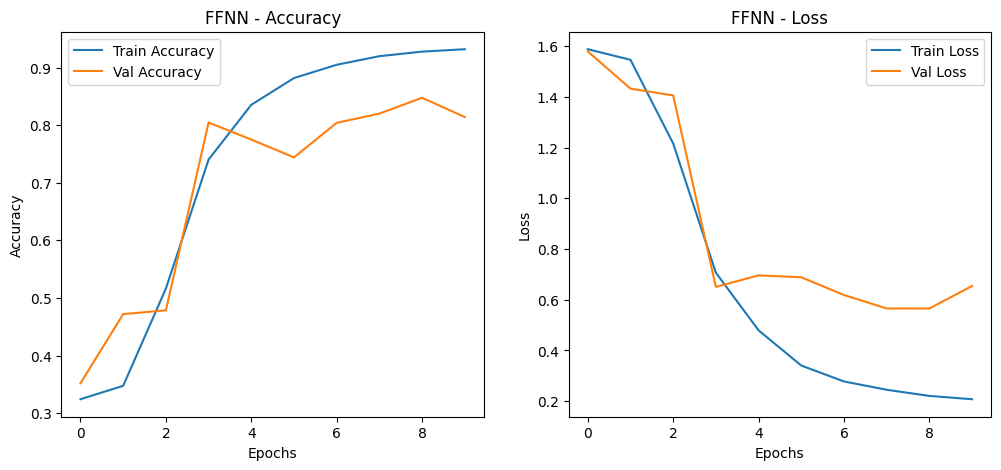

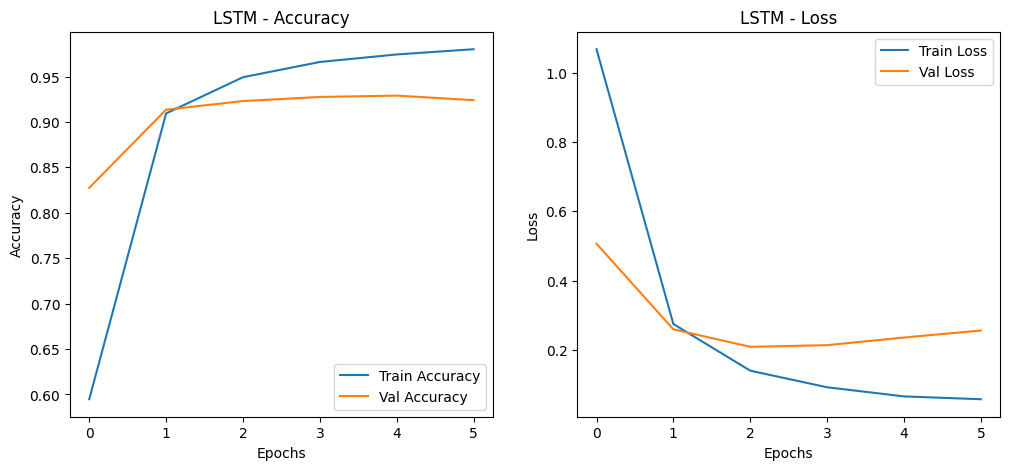

In [25]:
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_ffnn, "FFNN")
plot_history(history_lstm, "LSTM")

## evaluation function

In [29]:
def evaluate_dl(model, X_test_seq, y_test, name, le, k=3,save_plot=False):
  
    y_prob = model.predict(X_test_seq)
    y_pred = np.argmax(y_prob, axis=1)
   
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    try:
        if y_prob.shape[1] == 2:
            auc = roc_auc_score(y_test, y_prob[:, 1])
        else:
            auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    except Exception:
        auc = None

    em = np.mean(y_pred == y_test)

    try:
        top_k = top_k_accuracy_score(y_test, y_prob, k=k)
    except Exception:
        top_k = None

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    if auc is not None:
        print(f"AUC: {auc:.3f}")
    if top_k is not None:
        print(f"Top-{k} Accuracy: {top_k:.3f}")
    print(f"Exact Match (EM): {em:.3f}")

    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if save_plot:
        plt.savefig(f"../plots/{name}_confusion_matrix.png", dpi=300, bbox_inches='tight')
        print(f"Saved confusion matrix as {name}_confusion_matrix.png")

    plt.show()  
    plt.close() 

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "exact_match": em,
        "top_k_accuracy": top_k
    }

## run evaluation

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Feedforward NN Results:
Accuracy: 0.837 | Precision: 0.841 | Recall: 0.837 | F1: 0.830
AUC: 0.971
Top-3 Accuracy: 0.986
Exact Match (EM): 0.837

Classification Report:
               precision    recall  f1-score   support

       anger       0.88      0.80      0.84       275
        fear       0.98      0.56      0.71       224
         joy       0.84      0.96      0.89       695
        love       0.66      0.59      0.62       159
     sadness       0.85      0.92      0.88       581
    surprise       0.63      0.52      0.57        66

    accuracy                           0.84      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.84      0.84      0.83      2000

Saved confusion matrix as Feedforward NN_confusion_matrix.png


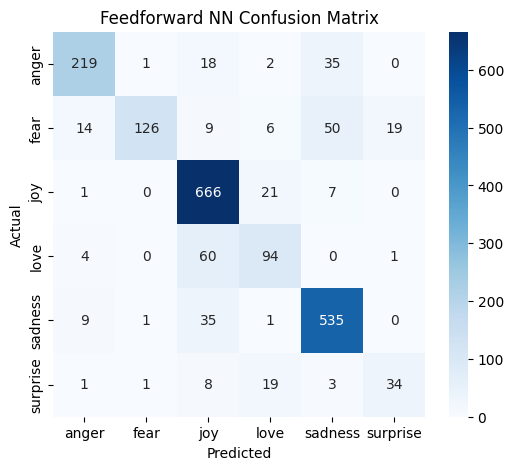

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step

LSTM Results:
Accuracy: 0.918 | Precision: 0.917 | Recall: 0.918 | F1: 0.916
AUC: 0.995
Top-3 Accuracy: 0.997
Exact Match (EM): 0.918

Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.91      0.91       275
        fear       0.86      0.92      0.89       224
         joy       0.92      0.95      0.94       695
        love       0.87      0.72      0.79       159
     sadness       0.95      0.97      0.96       581
    surprise       0.81      0.65      0.72        66

    accuracy                           0.92      2000
   macro avg       0.89      0.85      0.87      2000
weighted avg       0.92      0.92      0.92      2000

Saved confusion matrix as LSTM_confusion_matrix.png


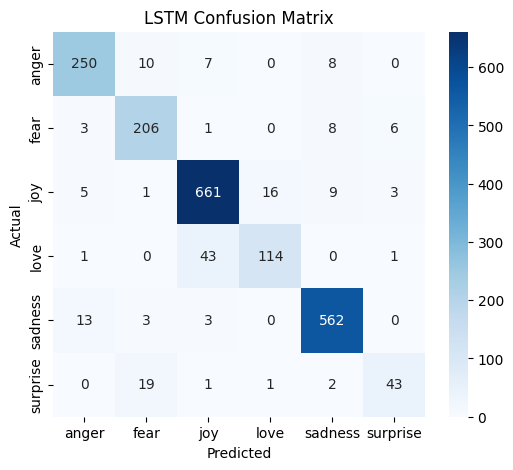

In [32]:
ffnn_metrics = evaluate_dl(model_ffnn, X_test_seq, y_test, "Feedforward NN", le,save_plot=True)
lstm_metrics = evaluate_dl(model_lstm, X_test_seq, y_test, "LSTM", le,save_plot=True)


## save models

In [33]:
metrics = {
    "FeedforwardNN": ffnn_metrics,
    "LSTM": lstm_metrics
}

with open("dl_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Deep Learning metrics saved to dl_metrics.json")


Deep Learning metrics saved to dl_metrics.json
